## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [ ]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [ ]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_window_size = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_window_size, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [ ]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-17 01:03:45,561] A new study created in memory with name: no-name-410b849e-f9b0-48d3-846f-64a1bb950b73


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:04:04,502] Trial 0 finished with value: 106.83033012421673 and parameters: {'window_size': 24, 'tcn_filters': 52, 'tcn_kernel_size': 3, 'dropout_rate': 0.493710567578706, 'attention_dim': 13}. Best is trial 0 with value: 106.83033012421673.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:04:09,772] Trial 1 finished with value: 61.34476670951164 and parameters: {'window_size': 12, 'tcn_filters': 39, 'tcn_kernel_size': 5, 'dropout_rate': 0.39357089203695406, 'attention_dim': 21}. Best is trial 1 with value: 61.34476670951164.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:04:16,374] Trial 2 finished with value: 141.66055812232477 and parameters: {'window_size': 40, 'tcn_filters': 43, 'tcn_kernel_size': 3, 'dropout_rate': 0.3384074773355493, 'attention_dim': 22}. Best is trial 1 with value: 61.34476670951164.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:04:38,943] Trial 3 finished with value: 198.54755207133823 and parameters: {'window_size': 41, 'tcn_filters': 69, 'tcn_kernel_size': 5, 'dropout_rate': 0.26950700019407364, 'attention_dim': 15}. Best is trial 1 with value: 61.34476670951164.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:04:46,444] Trial 4 finished with value: 121.77287951850096 and parameters: {'window_size': 39, 'tcn_filters': 84, 'tcn_kernel_size': 5, 'dropout_rate': 0.4723708906721863, 'attention_dim': 20}. Best is trial 1 with value: 61.34476670951164.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:04:56,645] Trial 5 finished with value: 138.2236142531027 and parameters: {'window_size': 33, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.173318244778693, 'attention_dim': 20}. Best is trial 1 with value: 61.34476670951164.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:05:03,777] Trial 6 finished with value: 51.99171579711144 and parameters: {'window_size': 15, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.22006184190976574, 'attention_dim': 13}. Best is trial 6 with value: 51.99171579711144.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:05:14,735] Trial 7 finished with value: 408.19417722412084 and parameters: {'window_size': 90, 'tcn_filters': 47, 'tcn_kernel_size': 4, 'dropout_rate': 0.48543563471899553, 'attention_dim': 31}. Best is trial 6 with value: 51.99171579711144.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:05:22,064] Trial 8 finished with value: 118.28125013987997 and parameters: {'window_size': 38, 'tcn_filters': 52, 'tcn_kernel_size': 5, 'dropout_rate': 0.43940558215073866, 'attention_dim': 27}. Best is trial 6 with value: 51.99171579711144.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:05:34,650] Trial 9 finished with value: 287.12494593857485 and parameters: {'window_size': 69, 'tcn_filters': 37, 'tcn_kernel_size': 5, 'dropout_rate': 0.3313633616385907, 'attention_dim': 21}. Best is trial 6 with value: 51.99171579711144.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:05:57,660] Trial 10 finished with value: 123.80091905467977 and parameters: {'window_size': 64, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.10785483569642282, 'attention_dim': 8}. Best is trial 6 with value: 51.99171579711144.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:06:04,985] Trial 11 finished with value: 49.91558068765016 and parameters: {'window_size': 17, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.2415537555580028, 'attention_dim': 14}. Best is trial 11 with value: 49.91558068765016.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:06:13,051] Trial 12 finished with value: 42.758503102073945 and parameters: {'window_size': 11, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.24889795329689368, 'attention_dim': 14}. Best is trial 12 with value: 42.758503102073945.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:06:20,296] Trial 13 finished with value: 41.20801723238132 and parameters: {'window_size': 10, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.2581262001451379, 'attention_dim': 10}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:06:42,825] Trial 14 finished with value: 160.24785286804953 and parameters: {'window_size': 95, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.2989612652353465, 'attention_dim': 8}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:06:53,461] Trial 15 finished with value: 51.87894433391756 and parameters: {'window_size': 53, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.19902251394429887, 'attention_dim': 10}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:06:58,310] Trial 16 finished with value: 59.66777794204203 and parameters: {'window_size': 10, 'tcn_filters': 126, 'tcn_kernel_size': 3, 'dropout_rate': 0.26871259054262414, 'attention_dim': 17}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:07:08,374] Trial 17 finished with value: 117.24684759394935 and parameters: {'window_size': 26, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.16749093276918592, 'attention_dim': 11}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:07:20,286] Trial 18 finished with value: 175.13227814644026 and parameters: {'window_size': 82, 'tcn_filters': 64, 'tcn_kernel_size': 2, 'dropout_rate': 0.3498170593724332, 'attention_dim': 16}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:07:26,896] Trial 19 finished with value: 95.77618365664006 and parameters: {'window_size': 23, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.25219304287283983, 'attention_dim': 11}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:07:50,749] Trial 20 finished with value: 133.8307877918452 and parameters: {'window_size': 49, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.29644887841941536, 'attention_dim': 24}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:07:58,132] Trial 21 finished with value: 43.192787440825086 and parameters: {'window_size': 18, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.23138228056070065, 'attention_dim': 17}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:08:08,378] Trial 22 finished with value: 58.0133340472353 and parameters: {'window_size': 29, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.22285033468667223, 'attention_dim': 18}. Best is trial 13 with value: 41.20801723238132.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:08:20,650] Trial 23 finished with value: 34.766253571278014 and parameters: {'window_size': 18, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.28139987520647225, 'attention_dim': 12}. Best is trial 23 with value: 34.766253571278014.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:08:27,967] Trial 24 finished with value: 107.48395759153394 and parameters: {'window_size': 19, 'tcn_filters': 104, 'tcn_kernel_size': 3, 'dropout_rate': 0.2738487119200746, 'attention_dim': 10}. Best is trial 23 with value: 34.766253571278014.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:08:33,081] Trial 25 finished with value: 34.18599027884389 and parameters: {'window_size': 11, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.3117229585932875, 'attention_dim': 11}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:08:42,809] Trial 26 finished with value: 69.29374184848079 and parameters: {'window_size': 31, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.3186972862749644, 'attention_dim': 12}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:08:49,563] Trial 27 finished with value: 67.4322298378197 and parameters: {'window_size': 21, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.3674178718508632, 'attention_dim': 8}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:08:58,899] Trial 28 finished with value: 55.81230410941335 and parameters: {'window_size': 10, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.2983275836905282, 'attention_dim': 10}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:09:07,520] Trial 29 finished with value: 59.16442258944654 and parameters: {'window_size': 25, 'tcn_filters': 89, 'tcn_kernel_size': 3, 'dropout_rate': 0.3791610175279417, 'attention_dim': 13}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:09:21,261] Trial 30 finished with value: 214.85861250596943 and parameters: {'window_size': 60, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.31474462957651284, 'attention_dim': 9}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:09:28,855] Trial 31 finished with value: 34.82161400848954 and parameters: {'window_size': 10, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.2716921114777178, 'attention_dim': 13}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:09:36,050] Trial 32 finished with value: 61.74963942728463 and parameters: {'window_size': 15, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.28050742928325856, 'attention_dim': 13}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:09:43,720] Trial 33 finished with value: 85.30245620904716 and parameters: {'window_size': 20, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.34570228596002966, 'attention_dim': 12}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:09:50,924] Trial 34 finished with value: 50.51471879796858 and parameters: {'window_size': 10, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.3171825031813633, 'attention_dim': 15}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:10:04,112] Trial 35 finished with value: 183.94406671398954 and parameters: {'window_size': 34, 'tcn_filters': 94, 'tcn_kernel_size': 3, 'dropout_rate': 0.2839982107261849, 'attention_dim': 11}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:10:16,630] Trial 36 finished with value: 54.977654713464815 and parameters: {'window_size': 25, 'tcn_filters': 84, 'tcn_kernel_size': 3, 'dropout_rate': 0.25824295309964634, 'attention_dim': 15}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:10:29,724] Trial 37 finished with value: 102.43265754482734 and parameters: {'window_size': 47, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.28545959418375216, 'attention_dim': 9}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:10:42,250] Trial 38 finished with value: 185.63936038021777 and parameters: {'window_size': 15, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.41065842883628, 'attention_dim': 12}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:10:49,005] Trial 39 finished with value: 74.22002759027615 and parameters: {'window_size': 29, 'tcn_filters': 104, 'tcn_kernel_size': 2, 'dropout_rate': 0.3301153538221352, 'attention_dim': 18}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:10:57,052] Trial 40 finished with value: 50.70879116598986 and parameters: {'window_size': 15, 'tcn_filters': 71, 'tcn_kernel_size': 4, 'dropout_rate': 0.2628573159280114, 'attention_dim': 24}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:11:04,315] Trial 41 finished with value: 99.25880746930456 and parameters: {'window_size': 14, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.25186588127689663, 'attention_dim': 14}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:11:08,774] Trial 42 finished with value: 38.52723006259275 and parameters: {'window_size': 11, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.3071133764424704, 'attention_dim': 14}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:11:15,907] Trial 43 finished with value: 49.39105610571066 and parameters: {'window_size': 21, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.3199766648832521, 'attention_dim': 12}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:11:23,641] Trial 44 finished with value: 38.422034612652375 and parameters: {'window_size': 14, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.29900326854243997, 'attention_dim': 30}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-17 01:11:35,665] Trial 45 finished with value: 187.03198094727549 and parameters: {'window_size': 38, 'tcn_filters': 111, 'tcn_kernel_size': 2, 'dropout_rate': 0.3064274781501144, 'attention_dim': 31}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-17 01:11:48,539] Trial 46 finished with value: 267.0621680982579 and parameters: {'window_size': 76, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.34246926918755705, 'attention_dim': 29}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:11:53,862] Trial 47 finished with value: 62.43075336064376 and parameters: {'window_size': 17, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.29386900615949346, 'attention_dim': 24}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:12:06,239] Trial 48 finished with value: 79.42767256417261 and parameters: {'window_size': 27, 'tcn_filters': 98, 'tcn_kernel_size': 3, 'dropout_rate': 0.35540540227704936, 'attention_dim': 27}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:12:13,329] Trial 49 finished with value: 151.03288819510215 and parameters: {'window_size': 43, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.33085305584723085, 'attention_dim': 19}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:12:21,279] Trial 50 finished with value: 244.12323613386187 and parameters: {'window_size': 35, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.27251403795853973, 'attention_dim': 16}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:12:28,571] Trial 51 finished with value: 45.46025579677201 and parameters: {'window_size': 12, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.30312097973667324, 'attention_dim': 32}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:12:36,623] Trial 52 finished with value: 37.02540732969105 and parameters: {'window_size': 13, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.26539010141720354, 'attention_dim': 22}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:12:43,989] Trial 53 finished with value: 46.261038487348415 and parameters: {'window_size': 13, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.2860306684157801, 'attention_dim': 22}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:12:52,855] Trial 54 finished with value: 56.38851737169961 and parameters: {'window_size': 22, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.23710084022757943, 'attention_dim': 28}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:13:05,274] Trial 55 finished with value: 47.09265093290066 and parameters: {'window_size': 18, 'tcn_filters': 60, 'tcn_kernel_size': 2, 'dropout_rate': 0.26809058951177134, 'attention_dim': 26}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:13:12,637] Trial 56 finished with value: 56.42522652031996 and parameters: {'window_size': 14, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.2428621473787411, 'attention_dim': 20}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:13:20,281] Trial 57 finished with value: 39.315070976295075 and parameters: {'window_size': 18, 'tcn_filters': 109, 'tcn_kernel_size': 5, 'dropout_rate': 0.3004341601820549, 'attention_dim': 14}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:13:27,518] Trial 58 finished with value: 36.77392216273032 and parameters: {'window_size': 10, 'tcn_filters': 83, 'tcn_kernel_size': 2, 'dropout_rate': 0.27804305912421595, 'attention_dim': 25}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:13:33,810] Trial 59 finished with value: 60.26223356106025 and parameters: {'window_size': 23, 'tcn_filters': 82, 'tcn_kernel_size': 3, 'dropout_rate': 0.20826502535571306, 'attention_dim': 22}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:13:40,991] Trial 60 finished with value: 44.25128966695644 and parameters: {'window_size': 17, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.27503551391221354, 'attention_dim': 25}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:13:45,366] Trial 61 finished with value: 50.762429291867626 and parameters: {'window_size': 10, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.28887974164706454, 'attention_dim': 29}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:13:54,034] Trial 62 finished with value: 45.4962446391789 and parameters: {'window_size': 13, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.3096460671738992, 'attention_dim': 23}. Best is trial 25 with value: 34.18599027884389.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:14:02,860] Trial 63 finished with value: 27.95189417967239 and parameters: {'window_size': 13, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.2604869661726665, 'attention_dim': 20}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 01:14:07,745] Trial 64 finished with value: 50.56769309438951 and parameters: {'window_size': 20, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.2560754902371278, 'attention_dim': 21}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:14:13,829] Trial 65 finished with value: 33.901215191698206 and parameters: {'window_size': 15, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.23268942065836612, 'attention_dim': 23}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:14:26,149] Trial 66 finished with value: 53.735424247456166 and parameters: {'window_size': 28, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.23892971617958408, 'attention_dim': 25}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:14:38,554] Trial 67 finished with value: 42.93842243699317 and parameters: {'window_size': 23, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.22550115736937404, 'attention_dim': 23}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:14:45,694] Trial 68 finished with value: 49.313082495012424 and parameters: {'window_size': 17, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.24968162727447663, 'attention_dim': 20}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:14:50,552] Trial 69 finished with value: 39.722517615561166 and parameters: {'window_size': 10, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.2673498760622611, 'attention_dim': 23}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:15:01,433] Trial 70 finished with value: 53.662567673905514 and parameters: {'window_size': 31, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.2787112172197698, 'attention_dim': 26}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:15:10,335] Trial 71 finished with value: 47.04528073507643 and parameters: {'window_size': 15, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.23159485787985284, 'attention_dim': 19}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:15:17,600] Trial 72 finished with value: 46.917985314380786 and parameters: {'window_size': 12, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.2634674855131093, 'attention_dim': 21}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:15:23,767] Trial 73 finished with value: 42.69313366465431 and parameters: {'window_size': 16, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.2963645026875587, 'attention_dim': 30}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:15:31,132] Trial 74 finished with value: 53.99778889431301 and parameters: {'window_size': 19, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.2824031589551705, 'attention_dim': 11}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:15:36,626] Trial 75 finished with value: 112.64531682605441 and parameters: {'window_size': 13, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.21636603633069867, 'attention_dim': 9}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:15:49,547] Trial 76 finished with value: 48.80076773943535 and parameters: {'window_size': 24, 'tcn_filters': 122, 'tcn_kernel_size': 3, 'dropout_rate': 0.25148179733241793, 'attention_dim': 22}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 01:16:10,898] Trial 77 finished with value: 276.8414331331035 and parameters: {'window_size': 100, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.24320462248572575, 'attention_dim': 27}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:16:20,913] Trial 78 finished with value: 55.70115445502089 and parameters: {'window_size': 21, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.32479473083318905, 'attention_dim': 21}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:16:28,527] Trial 79 finished with value: 42.16082489636059 and parameters: {'window_size': 12, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.2930182043166179, 'attention_dim': 13}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:16:51,172] Trial 80 finished with value: 129.60604513860642 and parameters: {'window_size': 64, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.3134948254240804, 'attention_dim': 25}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:16:55,826] Trial 81 finished with value: 33.51577565489781 and parameters: {'window_size': 10, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.3091500305107306, 'attention_dim': 12}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:17:00,585] Trial 82 finished with value: 51.462903109737624 and parameters: {'window_size': 14, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.2648366510757668, 'attention_dim': 11}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:17:05,543] Trial 83 finished with value: 43.75403698542098 and parameters: {'window_size': 10, 'tcn_filters': 88, 'tcn_kernel_size': 2, 'dropout_rate': 0.3355506590305326, 'attention_dim': 13}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:17:12,651] Trial 84 finished with value: 40.83944744825037 and parameters: {'window_size': 16, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.2774567740004801, 'attention_dim': 16}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:17:20,584] Trial 85 finished with value: 61.933097814054626 and parameters: {'window_size': 19, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.29001760763287016, 'attention_dim': 12}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-17 01:17:30,897] Trial 86 finished with value: 448.6615413593996 and parameters: {'window_size': 85, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.32001086919082367, 'attention_dim': 18}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:17:37,473] Trial 87 finished with value: 39.78177612493215 and parameters: {'window_size': 12, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.3058305946492177, 'attention_dim': 10}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:17:44,898] Trial 88 finished with value: 72.74402593896654 and parameters: {'window_size': 15, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.2587866448364585, 'attention_dim': 19}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:17:52,131] Trial 89 finished with value: 40.45391084234262 and parameters: {'window_size': 10, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.2757636602690402, 'attention_dim': 24}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:18:03,337] Trial 90 finished with value: 54.203846148973646 and parameters: {'window_size': 26, 'tcn_filters': 92, 'tcn_kernel_size': 3, 'dropout_rate': 0.2997010547334866, 'attention_dim': 10}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:18:07,287] Trial 91 finished with value: 55.3769516779748 and parameters: {'window_size': 12, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.31281127993977764, 'attention_dim': 14}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:18:14,262] Trial 92 finished with value: 112.59999078441531 and parameters: {'window_size': 16, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.2859102656009497, 'attention_dim': 12}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:18:18,831] Trial 93 finished with value: 39.40073051464917 and parameters: {'window_size': 13, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.3243277047325188, 'attention_dim': 11}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:18:31,132] Trial 94 finished with value: 45.74775750114841 and parameters: {'window_size': 20, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.27009762835328366, 'attention_dim': 13}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:18:39,322] Trial 95 finished with value: 51.54284842577019 and parameters: {'window_size': 18, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.3079937942665638, 'attention_dim': 15}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:18:48,777] Trial 96 finished with value: 33.70650407076523 and parameters: {'window_size': 10, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.2910975610101218, 'attention_dim': 23}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:18:55,093] Trial 97 finished with value: 60.23730206696125 and parameters: {'window_size': 14, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.2924437355729778, 'attention_dim': 23}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:19:03,241] Trial 98 finished with value: 35.438571756061435 and parameters: {'window_size': 10, 'tcn_filters': 86, 'tcn_kernel_size': 2, 'dropout_rate': 0.25723747992973206, 'attention_dim': 26}. Best is trial 63 with value: 27.95189417967239.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 01:19:15,647] Trial 99 finished with value: 144.84148629901793 and parameters: {'window_size': 55, 'tcn_filters': 70, 'tcn_kernel_size': 2, 'dropout_rate': 0.25637071813242723, 'attention_dim': 26}. Best is trial 63 with value: 27.95189417967239.


In [ ]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 13, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.2604869661726665, 'attention_dim': 20}


In [ ]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.07005660465149204
RMSE on Test dataset:  5.286955095295626
MSLE on Test dataset:  0.010677661034308611


### Save and Load the best model and related information

In [ ]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy', best_msle)

In [12]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy').item()

### Evaluate on Validate dataset

In [13]:
train_last_window_size = train_data[-loaded_best_window_size:]
val_data_extended = np.concatenate((train_last_window_size, val_data), axis=0)

val_windows, val_targets = create_dataset(val_data_extended, loaded_best_window_size)

In [14]:
# Testing the model on Validate dataset
y_pred_val = loaded_best_model.predict(val_windows)

7/7 [==============================] - 0s 4ms/step


In [15]:
# Evaluate on MAPE, RMSE, MSLE
val_targets = scaler.inverse_transform(val_targets.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)

mse = mean_squared_error(val_targets, y_pred_val)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(val_targets, y_pred_val)
msle = mean_squared_log_error(val_targets, y_pred_val)

In [16]:
# Evaluate on Validate dataset
print(f"MAPE on Validate dataset: ", mape)
print(f"RMSE on Validate dataset: ", rmse)
print(f"MSLE on Validate dataset: ", msle)

MAPE on Validate dataset:  0.03475953483365752
RMSE on Validate dataset:  4.685511038482871
MSLE on Validate dataset:  0.0016678725121369129


## Predicting the next 30 days

### Preparing the forecast date index

In [17]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [18]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 33ms/step


In [19]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[41.44944  40.760674 40.406044 40.247375 40.182186 40.155663 40.144993
 40.14068  40.138935 40.138226 40.13791  40.13352  39.8721   39.676426
 39.556076 39.48933  39.457165 39.442883 39.43668  39.43402  39.432903
 39.43244  39.432007 39.4156   39.381477 39.35217  39.332108 39.32013
 39.313793 39.310627]


## Visualization

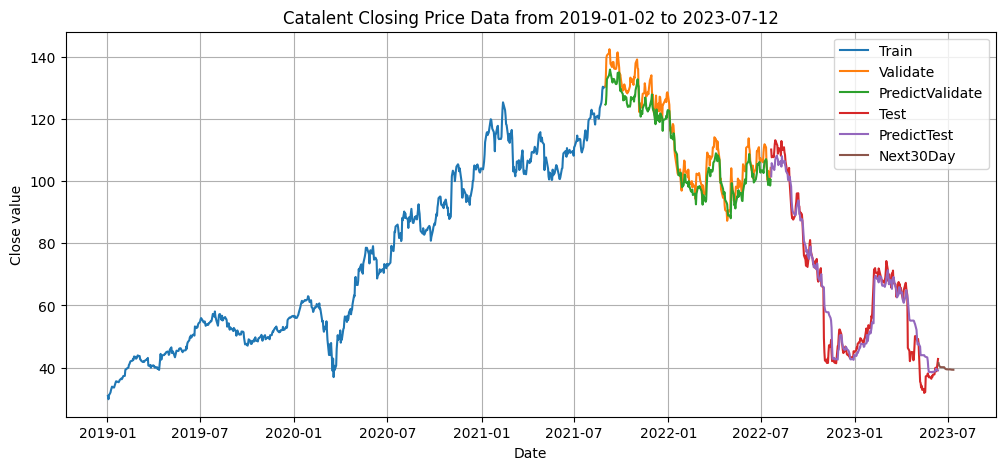

In [20]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_CTLT.png')
plt.show()